# Phase 5 Notebook

By: Jonah Devoy

In [1]:
import tensorflow as tf # Imports tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, LSTM,Bidirectional,Attention,Concatenate
from tensorflow.keras import regularizers, optimizers,losses
from tensorflow.keras.metrics import Recall,Precision,AUC,TruePositives,TrueNegatives,FalseNegatives,FalsePositives, SpecificityAtSensitivity,SensitivityAtSpecificity
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils import np_utils
import numpy as np
import pandas as pd 
import seaborn as sns
import sklearn
import keras
from keras.applications import MobileNet
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from imblearn.over_sampling import RandomOverSampler 
import imblearn
import matplotlib.pyplot as plt
import time
import os
import sklearn.metrics as m
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import skimage.io
import skimage.color
import skimage.filters
from sklearn.preprocessing import StandardScaler
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import metrics

2023-07-31 00:01:23.017987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# reading in the data
data = pd.read_csv('/Users/jdapeman/Documents/skin2/archive-2/hmnist_28_28_RGB.csv')
data

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


In [3]:
# dropping the taget label column from x
y = data['label']
x = data.drop(columns = ['label'])

In [4]:
# reading in the metadata csv
meta_data = pd.read_csv('/Users/jdapeman/Documents/skin2/archive-2/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# relabeling the disease names
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

In [6]:
classes = {'mel':0 ,'vasc':1,'df':2,'nv':3,'bkl':4,'bcc':5,'ak':6}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

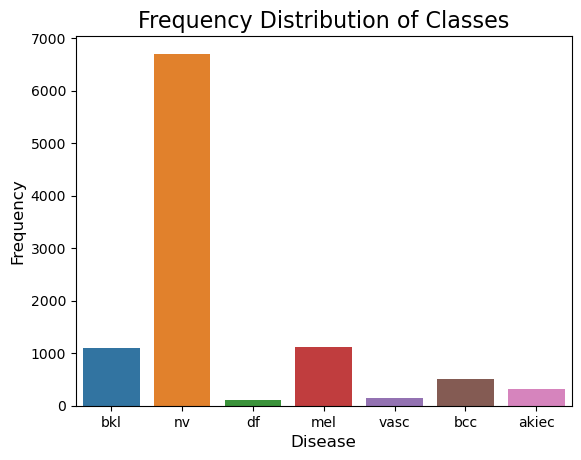

In [7]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [8]:
# reshaping x for out CNN model
x = np.array(x).reshape(-1,28,28,3)

In [9]:
x.shape

(10015, 28, 28, 3)

In [10]:
#80/20 split 
x_train_, x_test_, y_train_, y_test_ = train_test_split(x, y, test_size=0.20 ,random_state=42)

In [11]:
# standardization or normalization process on the training and test data
x_train = np.asarray(x_train_)
x_test = np.asarray(x_test_)

num_train_samples, height, width, channels = x_train.shape
num_test_samples = x_test.shape[0]

x_train = x_train.reshape(num_train_samples, -1)
x_test = x_test.reshape(num_test_samples, -1)

combined_data = np.vstack((x_train, x_test))
scaler = StandardScaler()
scaler.fit(combined_data)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

x_train = x_train.reshape(num_train_samples, height, width, channels)
x_test = x_test.reshape(num_test_samples, height, width, channels)

In [12]:
y_train = to_categorical(y_train_, num_classes = 7)
y_test = to_categorical(y_test_, num_classes = 7)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                            test_size = 0.1, 
                                                            random_state = 2)

In [14]:
y_train.shape

(7210, 7)

In [15]:
x_train.shape

(7210, 28, 28, 3)

- The given function blockred(inp, filters) creates a block or a module for a neural network that applies a combination of different convolutional layers and pooling operations to the input inp with a specified number of filters. The function performs three sets of operations in parallel:

- Inception Block: It consists of a 1x1 convolution layer followed by max pooling and batch normalization.

- VGG + SqueezeNet Block: It involves two consecutive 3x3 convolutional layers, followed by max pooling, batch normalization, and dropout.

- InceptionResNet + SqueezeNet Block: It applies a combination of 3x3 and 1x1 convolutional layers followed by max pooling and batch normalization. The output of this block is obtained by adding the outputs of the Inception, VGG + SqueezeNet, and InceptionResNet + SqueezeNet blocks element-wise.

- The final output of this function is the combined result of all three operations, representing the features extracted from the input inp using various convolutional operations. This type of block is commonly used in deep learning architectures, especially in models that utilize a combination of inception-like and residual-like blocks to extract hierarchical features.

In [16]:
def blockred(inp,filters):
    #Inception
    x = Conv2D(filters, 1, activation="relu",padding='same',use_bias=False)(inp)
    x = layers.MaxPooling2D(2)(x)
    x = BatchNormalization(axis=1)(x)
    
    #VGG + SQuizenet
    y = Conv2D(filters*2,3,activation="relu", padding='same',use_bias=False,)(inp)
    y = Conv2D(filters,3,activation="relu", padding='same',use_bias=False,)(y)
    y = layers.MaxPooling2D(2)(y)
    y = BatchNormalization(axis=1)(y)
    y = Dropout(0.25)(y)
    
    #InceptionResnet+Squize
    z = Conv2D(filters*2, 3, activation="relu", padding='same',use_bias=False)(inp)
    z = Conv2D(filters, 1, activation="relu", padding='same',use_bias=False)(inp)  
    z = layers.MaxPooling2D(2)(z)
    z = BatchNormalization(axis=1)(z)
    output1 = layers.add([x,y,z])
    return output1


- This code defines a convolutional neural network (CNN) architecture for a multi-class classification task on 28x28 RGB images. The architecture consists of several layers, including three blocks defined by the blockred() function, followed by fully connected layers.

- Overall, this code creates a CNN model with three blocks of convolutional operations followed by fully connected layers for multi-class classification on 28x28 RGB images. The blocks defined by blockred() incorporate various convolutional layers, pooling, batch normalization, and dropout to extract meaningful features from the input data.

In [17]:
Name= "CNN0"

# An input layer for the model is defined with the shape (28, 28, 3), 
# representing 28x28 RGB images. The name "img" is given to this input layer.
inputs = keras.Input(shape=(28,28,3), name="img")


# A 2D convolutional layer with 32 filters, a kernel size of 3x3, 
# and ReLU activation function is applied to the input layer.
x = layers.Conv2D(32, 3, activation="relu")(inputs)


# The function blockred() is called with the output of the previous 
# convolutional layer and 32 filters. It creates the first block of operations.
bl1=blockred(x,32)


# The function blockred() is called again with the output of the
# first block (bl1) and 64 filters. It creates the second block of operations.
bl2=blockred(bl1,64)


# The function blockred() is called again with the output of the second block 
# (bl2) and 64 filters. It creates the third block of operations.
bl3=blockred(bl2,64)


# y = Conv2D(filters=128, kernel_size=(5, 5), activation='relu')(bl3)
# y = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(y)
# y = MaxPooling2D(pool_size=(2, 2))(y)
# y = BatchNormalization(axis=-1)(y)
# y = Dropout(0.25)(y)

# The output of the third block is flattened to prepare it for the fully connected layers.
y = Flatten()(bl3)

#  A fully connected layer with 256 units and ReLU activation function is applied.
y = Dense(256, activation='relu')(y)

#  A dropout layer is added to help prevent overfitting.
y = Dropout(0.5)(y)

# Another fully connected layer with 64 units and ReLU activation function is applied.
y = Dense(64, activation='relu')(y)

#  Another dropout layer is added.
y = Dropout(0.5)(y)


# The final fully connected layer with 7 units (assuming it's a 7-class classification task) 
# and a softmax activation function is applied to get the model's output probabilities for each class.
outputs=Dense(7, activation='softmax')(y)

# The Keras Model is created by specifying the inputs and outputs.
# It represents the complete CNN architecture.
model = keras.Model(inputs, outputs, name=Name)

# The summary of the model's architecture is printed, showing the layer types,
# output shapes, and the number of trainable parameters.
print(model.summary())




Model: "CNN0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 26, 26, 32)           896       ['img[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)           (None, 26, 26, 64)           18432     ['conv2d[0][0]']              
                                                                                                  
 conv2d_3 (Conv2D)           (None, 26, 26, 32)           18432     ['conv2d_2[0][0]']            
                                                                                               

                                                                                                  
 conv2d_15 (Conv2D)          (None, 6, 6, 64)             4096      ['add_1[0][0]']               
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 3, 3, 64)             0         ['conv2d_11[0][0]']           
 g2D)                                                                                             
                                                                                                  
 batch_normalization_7 (Bat  (None, 3, 3, 64)             12        ['max_pooling2d_7[0][0]']     
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 64)             0         ['conv2d_15[0][0]']           
 g2D)     

- This code defines a callback function for a TensorFlow/Keras model called ModelCheckpoint. A callback is a set of functions applied at various stages during training to perform specific actions. In this case, the ModelCheckpoint callback saves the best model (based on validation accuracy) during training to a file named 'best_model.h5'.

- During the training process, the ModelCheckpoint callback will continuously check the validation accuracy of the model. If the validation accuracy improves (increases), it will save the model to the specified file path. This ensures that you have access to the best-performing model after training, rather than the final model at the last epoch. It can be useful for later evaluation or deployment of the model.

In [23]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='auto',
                                                 verbose=1, save_best_only=True)

In [24]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=20,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)  

datagen.fit(x_train)

In [25]:
num_classes = 7
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.CategoricalCrossentropy(),  
    metrics=[
        'acc', 
        metrics.Recall(),
        metrics.Precision(),
        metrics.AUC(),
        metrics.TruePositives(),
        metrics.TrueNegatives(),
        metrics.FalseNegatives(),
        metrics.FalsePositives(),
    ]
)

In [26]:
batch_size = 32
epochs = 50

history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[callback])

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.3482 - acc: 0.6035 - recall_1: 0.4648 - precision_1: 0.7193 - auc_1: 0.8670 - true_positives_1: 3336.0000 - true_negatives_1: 41766.0000 - false_negatives_1: 3842.0000 - false_positives_1: 1302.0000
Epoch 1: val_acc improved from -inf to 0.65087, saving model to best_model.h5
225/225 [==============================] - 31s 128ms/step - loss: 1.3482 - acc: 0.6035 - recall_1: 0.4648 - precision_1: 0.7193 - auc_1: 0.8670 - true_positives_1: 3336.0000 - true_negatives_1: 41766.0000 - false_negatives_1: 3842.0000 - false_positives_1: 1302.0000 - val_loss: 1.0621 - val_acc: 0.6509 - val_recall_1: 0.3978 - val_precision_1: 0.8886 - val_auc_1: 0.9110 - val_true_positives_1: 319.0000 - val_true_negatives_1: 4772.0000 - val_false_negatives_1: 483.0000 - val_false_positives_1: 40.0000
Epoch 2/50


/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - ETA: 0s - loss: 1.0380 - acc: 0.6610 - recall_1: 0.4983 - precision_1: 0.7990 - auc_1: 0.9104 - true_positives_1: 3577.0000 - true_negatives_1: 42168.0000 - false_negatives_1: 3601.0000 - false_positives_1: 900.0000
Epoch 2: val_acc did not improve from 0.65087
225/225 [==============================] - 30s 133ms/step - loss: 1.0380 - acc: 0.6610 - recall_1: 0.4983 - precision_1: 0.7990 - auc_1: 0.9104 - true_positives_1: 3577.0000 - true_negatives_1: 42168.0000 - false_negatives_1: 3601.0000 - false_positives_1: 900.0000 - val_loss: 0.9583 - val_acc: 0.6446 - val_recall_1: 0.4564 - val_precision_1: 0.8714 - val_auc_1: 0.9240 - val_true_positives_1: 366.0000 - val_true_negatives_1: 4758.0000 - val_false_negatives_1: 436.0000 - val_false_positives_1: 54.0000
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 0.9714 - acc: 0.6644 - recall_1: 0.5183 - precision_1: 0.8089 - auc_1: 0.9221 - true_positives_1: 3720.0000 - true_nega

Epoch 12/50
225/225 [==============================] - ETA: 0s - loss: 0.7790 - acc: 0.7165 - recall_1: 0.6094 - precision_1: 0.8328 - auc_1: 0.9491 - true_positives_1: 4374.0000 - true_negatives_1: 42190.0000 - false_negatives_1: 2804.0000 - false_positives_1: 878.0000
Epoch 12: val_acc did not improve from 0.69202
225/225 [==============================] - 35s 155ms/step - loss: 0.7790 - acc: 0.7165 - recall_1: 0.6094 - precision_1: 0.8328 - auc_1: 0.9491 - true_positives_1: 4374.0000 - true_negatives_1: 42190.0000 - false_negatives_1: 2804.0000 - false_positives_1: 878.0000 - val_loss: 0.8098 - val_acc: 0.6870 - val_recall_1: 0.6047 - val_precision_1: 0.7912 - val_auc_1: 0.9438 - val_true_positives_1: 485.0000 - val_true_negatives_1: 4684.0000 - val_false_negatives_1: 317.0000 - val_false_positives_1: 128.0000
Epoch 13/50
225/225 [==============================] - ETA: 0s - loss: 0.7732 - acc: 0.7109 - recall_1: 0.6126 - precision_1: 0.8347 - auc_1: 0.9496 - true_positives_1: 4397.0

Epoch 22/50
225/225 [==============================] - ETA: 0s - loss: 0.6966 - acc: 0.7471 - recall_1: 0.6565 - precision_1: 0.8405 - auc_1: 0.9590 - true_positives_1: 4712.0000 - true_negatives_1: 42174.0000 - false_negatives_1: 2466.0000 - false_positives_1: 894.0000
Epoch 22: val_acc did not improve from 0.72195
225/225 [==============================] - 33s 146ms/step - loss: 0.6966 - acc: 0.7471 - recall_1: 0.6565 - precision_1: 0.8405 - auc_1: 0.9590 - true_positives_1: 4712.0000 - true_negatives_1: 42174.0000 - false_negatives_1: 2466.0000 - false_positives_1: 894.0000 - val_loss: 0.7172 - val_acc: 0.7195 - val_recall_1: 0.6209 - val_precision_1: 0.8484 - val_auc_1: 0.9564 - val_true_positives_1: 498.0000 - val_true_negatives_1: 4723.0000 - val_false_negatives_1: 304.0000 - val_false_positives_1: 89.0000
Epoch 23/50
225/225 [==============================] - ETA: 0s - loss: 0.6863 - acc: 0.7462 - recall_1: 0.6591 - precision_1: 0.8427 - auc_1: 0.9603 - true_positives_1: 4731.00

Epoch 32/50
225/225 [==============================] - ETA: 0s - loss: 0.6628 - acc: 0.7538 - recall_1: 0.6725 - precision_1: 0.8420 - auc_1: 0.9631 - true_positives_1: 4827.0000 - true_negatives_1: 42162.0000 - false_negatives_1: 2351.0000 - false_positives_1: 906.0000
Epoch 32: val_acc did not improve from 0.73441
225/225 [==============================] - 31s 139ms/step - loss: 0.6628 - acc: 0.7538 - recall_1: 0.6725 - precision_1: 0.8420 - auc_1: 0.9631 - true_positives_1: 4827.0000 - true_negatives_1: 42162.0000 - false_negatives_1: 2351.0000 - false_positives_1: 906.0000 - val_loss: 0.6924 - val_acc: 0.7282 - val_recall_1: 0.6521 - val_precision_1: 0.8210 - val_auc_1: 0.9590 - val_true_positives_1: 523.0000 - val_true_negatives_1: 4698.0000 - val_false_negatives_1: 279.0000 - val_false_positives_1: 114.0000
Epoch 33/50
225/225 [==============================] - ETA: 0s - loss: 0.6372 - acc: 0.7657 - recall_1: 0.6888 - precision_1: 0.8534 - auc_1: 0.9655 - true_positives_1: 4944.0

Epoch 42/50
225/225 [==============================] - ETA: 0s - loss: 0.6041 - acc: 0.7785 - recall_1: 0.7105 - precision_1: 0.8499 - auc_1: 0.9687 - true_positives_1: 5100.0000 - true_negatives_1: 42167.0000 - false_negatives_1: 2078.0000 - false_positives_1: 901.0000
Epoch 42: val_acc did not improve from 0.74190
225/225 [==============================] - 33s 145ms/step - loss: 0.6041 - acc: 0.7785 - recall_1: 0.7105 - precision_1: 0.8499 - auc_1: 0.9687 - true_positives_1: 5100.0000 - true_negatives_1: 42167.0000 - false_negatives_1: 2078.0000 - false_positives_1: 901.0000 - val_loss: 0.7283 - val_acc: 0.7182 - val_recall_1: 0.6334 - val_precision_1: 0.8260 - val_auc_1: 0.9546 - val_true_positives_1: 508.0000 - val_true_negatives_1: 4705.0000 - val_false_negatives_1: 294.0000 - val_false_positives_1: 107.0000
Epoch 43/50
225/225 [==============================] - ETA: 0s - loss: 0.6088 - acc: 0.7750 - recall_1: 0.7021 - precision_1: 0.8493 - auc_1: 0.9683 - true_positives_1: 5040.0

In [27]:
model.save(Name+'.h5')

pd.DataFrame.from_dict(history.history).to_csv(Name+'.csv',index=False)

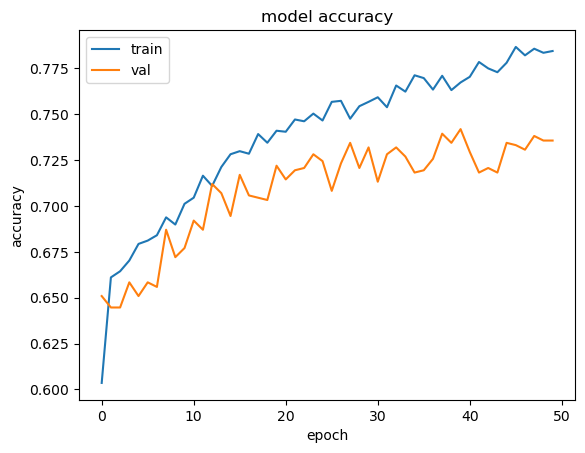

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

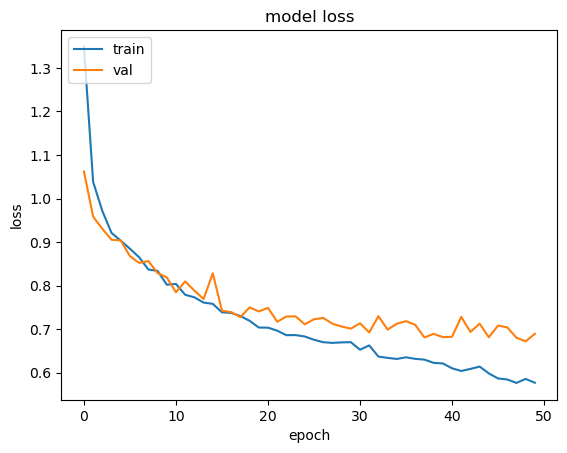

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
model.evaluate(x_test, y_test, verbose=1)

63/63 [==============================] - 2s 25ms/step - loss: 0.6678 - acc: 0.7649 - recall_1: 0.6900 - precision_1: 0.8310 - auc_1: 0.9634 - true_positives_1: 1382.0000 - true_negatives_1: 11737.0000 - false_negatives_1: 621.0000 - false_positives_1: 281.0000


[0.6678413152694702,
 0.7648527026176453,
 0.6899650692939758,
 0.8310282826423645,
 0.9633909463882446,
 1382.0,
 11737.0,
 621.0,
 281.0]

In [31]:
model.save_weights('best_model_weights.h5')

63/63 [==============================] - 2s 25ms/step


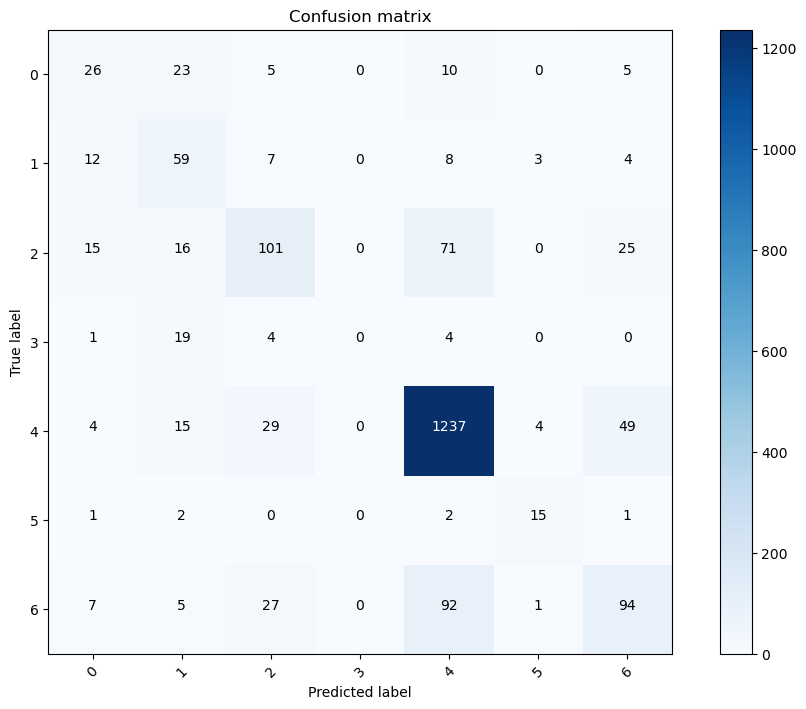

In [32]:
import itertools
from sklearn.metrics import confusion_matrix
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig, ax = plt.subplots(figsize = (10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.argmax(y_test,axis=1), Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes.values()) 
    
    


In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
Y_pred = np.argmax(model.predict(x_test),axis=1)
print(classification_report(np.float32(np.argmax(y_test,axis=1)), Y_pred.round()))
print('Classification Report')

63/63 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

         0.0       0.31      0.33      0.32        69
         1.0       0.39      0.74      0.51        93
         2.0       0.55      0.41      0.47       228
         3.0       0.00      0.00      0.00        28
         4.0       0.88      0.90      0.89      1338
         5.0       0.79      0.52      0.63        21
         6.0       0.51      0.46      0.48       226

    accuracy                           0.75      2003
   macro avg       0.49      0.48      0.47      2003
weighted avg       0.74      0.75      0.74      2003

Classification Report


/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

transfer learning --

In [33]:
x_train.shape

(7210, 28, 28, 3)

In [34]:
x_test.shape

(2003, 28, 28, 3)

In [147]:
y_train.shape

(7210, 7)

In [148]:
y_test.shape

(2003, 7)

In [161]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt
import numpy as np

In [162]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"


In [163]:
mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224, 224, 3))


In [164]:
mobile_net_layers.trainable = False


In [165]:
neural_net = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(7,activation='softmax')
])

In [166]:
neural_net.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_15 (Dropout)        (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 7)                 8967      
                                                                 
Total params: 2266951 (8.65 MB)
Trainable params: 8967 (35.03 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [167]:
neural_net.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc',Recall(),Precision(),AUC(),TruePositives(),TrueNegatives(),FalseNegatives(),FalsePositives()])

In [168]:
history = neural_net.fit(datagen.flow(x_train,y_train, batch_size=10),
                              epochs = 50, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 10,
                              callbacks=[callback])

Epoch 1/50
721/721 [==============================] - ETA: 0s - loss: 0.9717 - acc: 0.6827 - recall_10: 0.6239 - precision_10: 0.7546 - auc_10: 0.9232 - true_positives_10: 4498.0000 - true_negatives_10: 41797.0000 - false_negatives_10: 2712.0000 - false_positives_10: 1463.0000
Epoch 1: saving model to best_Resnet.h5


/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


721/721 [==============================] - 152s 205ms/step - loss: 0.9717 - acc: 0.6827 - recall_10: 0.6239 - precision_10: 0.7546 - auc_10: 0.9232 - true_positives_10: 4498.0000 - true_negatives_10: 41797.0000 - false_negatives_10: 2712.0000 - false_positives_10: 1463.0000 - val_loss: 0.9139 - val_acc: 0.6870 - val_recall_10: 0.6372 - val_precision_10: 0.7604 - val_auc_10: 0.9326 - val_true_positives_10: 511.0000 - val_true_negatives_10: 4651.0000 - val_false_negatives_10: 291.0000 - val_false_positives_10: 161.0000
Epoch 2/50
721/721 [==============================] - ETA: 0s - loss: 0.8616 - acc: 0.7087 - recall_10: 0.6492 - precision_10: 0.7741 - auc_10: 0.9394 - true_positives_10: 4681.0000 - true_negatives_10: 41894.0000 - false_negatives_10: 2529.0000 - false_positives_10: 1366.0000
Epoch 2: saving model to best_Resnet.h5
721/721 [==============================] - 127s 176ms/step - loss: 0.8616 - acc: 0.7087 - recall_10: 0.6492 - precision_10: 0.7741 - auc_10: 0.9394 - true_posi

Epoch 21/50
721/721 [==============================] - ETA: 0s - loss: 0.7693 - acc: 0.7312 - recall_10: 0.6810 - precision_10: 0.7916 - auc_10: 0.9513 - true_positives_10: 4910.0000 - true_negatives_10: 41967.0000 - false_negatives_10: 2300.0000 - false_positives_10: 1293.0000
Epoch 21: saving model to best_Resnet.h5
721/721 [==============================] - 120s 166ms/step - loss: 0.7693 - acc: 0.7312 - recall_10: 0.6810 - precision_10: 0.7916 - auc_10: 0.9513 - true_positives_10: 4910.0000 - true_negatives_10: 41967.0000 - false_negatives_10: 2300.0000 - false_positives_10: 1293.0000 - val_loss: 0.8376 - val_acc: 0.6658 - val_recall_10: 0.6122 - val_precision_10: 0.7485 - val_auc_10: 0.9420 - val_true_positives_10: 491.0000 - val_true_negatives_10: 4647.0000 - val_false_negatives_10: 311.0000 - val_false_positives_10: 165.0000
Epoch 22/50
721/721 [==============================] - ETA: 0s - loss: 0.7744 - acc: 0.7313 - recall_10: 0.6847 - precision_10: 0.7892 - auc_10: 0.9508 - tru

Epoch 31/50
721/721 [==============================] - ETA: 0s - loss: 0.7704 - acc: 0.7305 - recall_10: 0.6804 - precision_10: 0.7846 - auc_10: 0.9516 - true_positives_10: 4906.0000 - true_negatives_10: 41913.0000 - false_negatives_10: 2304.0000 - false_positives_10: 1347.0000
Epoch 31: saving model to best_Resnet.h5
721/721 [==============================] - 117s 162ms/step - loss: 0.7704 - acc: 0.7305 - recall_10: 0.6804 - precision_10: 0.7846 - auc_10: 0.9516 - true_positives_10: 4906.0000 - true_negatives_10: 41913.0000 - false_negatives_10: 2304.0000 - false_positives_10: 1347.0000 - val_loss: 0.8797 - val_acc: 0.7032 - val_recall_10: 0.6596 - val_precision_10: 0.7493 - val_auc_10: 0.9397 - val_true_positives_10: 529.0000 - val_true_negatives_10: 4635.0000 - val_false_negatives_10: 273.0000 - val_false_positives_10: 177.0000
Epoch 32/50
721/721 [==============================] - ETA: 0s - loss: 0.7569 - acc: 0.7350 - recall_10: 0.6865 - precision_10: 0.7896 - auc_10: 0.9533 - tru

Epoch 41/50
721/721 [==============================] - ETA: 0s - loss: 0.7700 - acc: 0.7304 - recall_10: 0.6842 - precision_10: 0.7839 - auc_10: 0.9517 - true_positives_10: 4933.0000 - true_negatives_10: 41900.0000 - false_negatives_10: 2277.0000 - false_positives_10: 1360.0000
Epoch 41: saving model to best_Resnet.h5
721/721 [==============================] - 120s 166ms/step - loss: 0.7700 - acc: 0.7304 - recall_10: 0.6842 - precision_10: 0.7839 - auc_10: 0.9517 - true_positives_10: 4933.0000 - true_negatives_10: 41900.0000 - false_negatives_10: 2277.0000 - false_positives_10: 1360.0000 - val_loss: 0.9400 - val_acc: 0.7070 - val_recall_10: 0.6559 - val_precision_10: 0.7645 - val_auc_10: 0.9344 - val_true_positives_10: 526.0000 - val_true_negatives_10: 4650.0000 - val_false_negatives_10: 276.0000 - val_false_positives_10: 162.0000
Epoch 42/50
721/721 [==============================] - ETA: 0s - loss: 0.7593 - acc: 0.7362 - recall_10: 0.6895 - precision_10: 0.7908 - auc_10: 0.9534 - tru

In [173]:
# evaluate the neural_net model
evaluation = neural_net.evaluate(x_test, y_test)
print("Loss: {:.2f}".format(evaluation[0]))
print("Accuracy: {:.2%}".format(evaluation[1]))

63/63 [==============================] - 23s 371ms/step - loss: 0.8321 - acc: 0.7024 - recall_10: 0.6400 - precision_10: 0.7667 - auc_10: 0.9432 - true_positives_10: 1282.0000 - true_negatives_10: 11628.0000 - false_negatives_10: 721.0000 - false_positives_10: 390.0000
Loss: 0.83
Accuracy: 70.24%


63/63 [==============================] - 21s 316ms/step


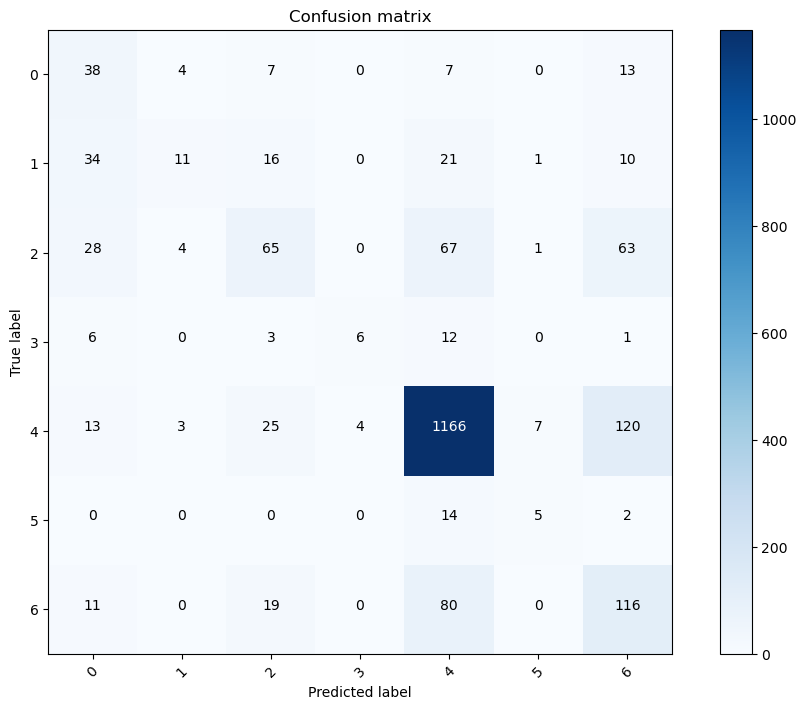

In [176]:
import itertools
from sklearn.metrics import confusion_matrix
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig, ax = plt.subplots(figsize = (10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Y_pred = neural_net.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.argmax(y_test,axis=1), Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes.values()) 

In [177]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
Y_pred = np.argmax(neural_net.predict(x_test),axis=1)
print(classification_report(np.float32(np.argmax(y_test,axis=1)), Y_pred.round()))
print('Classification Report')

63/63 [==============================] - 21s 337ms/step
              precision    recall  f1-score   support

         0.0       0.29      0.55      0.38        69
         1.0       0.50      0.12      0.19        93
         2.0       0.48      0.29      0.36       228
         3.0       0.60      0.21      0.32        28
         4.0       0.85      0.87      0.86      1338
         5.0       0.36      0.24      0.29        21
         6.0       0.36      0.51      0.42       226

    accuracy                           0.70      2003
   macro avg       0.49      0.40      0.40      2003
weighted avg       0.71      0.70      0.69      2003

Classification Report


In [181]:
# plot auc for neural_net

In [184]:
# save the neural_net model so that it can be used in a webpage format for perdiction on outside data 

In [190]:
# plot auc for neural_net
from sklearn.metrics import roc_auc_score

# Compute the probabilities for each class
Y_pred_prob = neural_net.predict(x_test)


# Compute the AUROC for each class
auc_scores = roc_auc_score(y_test, Y_pred_prob, average=None)

# Determine the average AUROC
average_auc = np.mean(auc_scores)

# Print the AUROC scores for each class
for i, auc in enumerate(auc_scores):
    print(f"AUROC for class {i}: {auc}")

# Print the average AUROC
print(f"Average AUROC: {average_auc}")

63/63 [==============================] - 20s 306ms/step
AUROC for class 0: 0.9075880880655846
AUROC for class 1: 0.9148961324100658
AUROC for class 2: 0.8066938472942922
AUROC for class 3: 0.914755877034358
AUROC for class 4: 0.8838868471627499
AUROC for class 5: 0.8831627504685022
AUROC for class 6: 0.8317986464210836
Average AUROC: 0.8775403126938052


In [188]:
# save the neural_net model
neural_net.save('my_model.keras')

In [82]:
input_size = 28
output_size = 224
bin_size = input_size // output_size

(28, 28, 3)

In [157]:
import cv2
IMG_SIZ = 224

bh2 = []
for x in x_val:
    
    bh2.append(cv2.resize(x,(IMG_SIZ,IMG_SIZ),3))
    
bhh3 = np.array(bh2)
#print(bh.shape)
#print(bhh.shape)

    

In [158]:
bhh3.shape

(802, 224, 224, 3)

In [159]:
x_val = bhh3

In [160]:
x_val.shape

(802, 224, 224, 3)

In [38]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [40]:
X_train_pad= np.pad(x_train,((0,0),(2,2),(2,2),(0,0)),'mean')

In [41]:
X_test_pad= np.pad(x_test,((0,0),(2,2),(2,2),(0,0)),'mean')

In [45]:
img_shape =(32,32,3)

Name= "ResNet"
classifier = ResNet152V2(
            include_top = False,input_shape=img_shape,
             weights='imagenet'
           )
fine_tune_at = 555
for layer in classifier.layers[:fine_tune_at]:
    layer.trainable = False
    
"""
# 
Name= "EfficientNetB7"
classifier = EfficientNetB7(
            include_top = False,input_shape=img_shape,
             weights='imagenet'
           )
fine_tune_at = 790
for layer in classifier.layers[:fine_tune_at]:
    layer.trainable = False

# 
Name= "VGG19"
classifier = VGG19(
            include_top = False,input_shape=img_shape,
             weights='imagenet'
           )

fine_tune_at = 20
for layer in classifier.layers[:fine_tune_at]:
    layer.trainable = False
"""
model = Sequential()
model.add(classifier)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 1, 1, 2048)        58331648  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_11 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_5 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 128)              

In [43]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_Resnet.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)
model.compile(optimizer= keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy() ,
              metrics=['acc',Recall(),Precision(),AUC(),TruePositives(),TrueNegatives(),FalseNegatives(),FalsePositives()])
history = model.fit(datagen.flow(x_train,y_train, batch_size=32),
                              epochs = 20, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 32,
                              callbacks=[callback])

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.7246 - acc: 0.5447 - recall_1: 0.3826 - precision_1: 0.6617 - auc_1: 0.7926 - true_positives_1: 2746.0000 - true_negatives_1: 41664.0000 - false_negatives_1: 4432.0000 - false_positives_1: 1404.0000

ValueError: in user code:

    File "/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/keras/src/engine/training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/keras/src/engine/training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/keras/src/engine/training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/keras/src/engine/training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/jdapeman/anaconda3/envs/apple/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 28, 28, 3)


In [48]:
model.save(Name+'.h5')

pd.DataFrame.from_dict(history.history).to_csv(Name+'.csv',index=False)

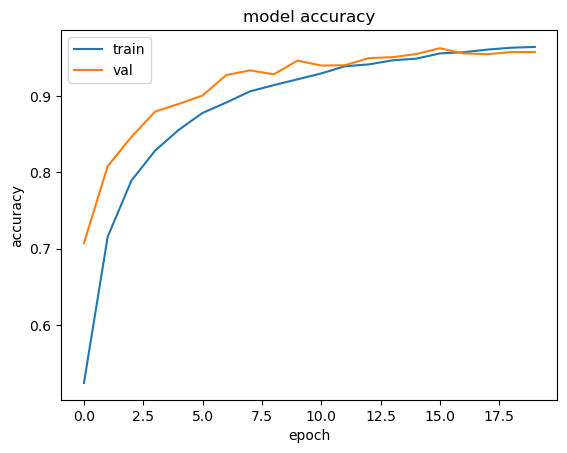

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
# plot in a confusion matrix the model scores and all the accuracy, f1, recall and percision scores 
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# Get the predicted labels from the model
y_pred = model.predict(X_test_pad)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), y_pred)

# Calculate the accuracy, f1 score, recall, and precision
accuracy = accuracy_score(np.argmax(Y_test, axis=1), y_pred)
f1 = f1_score(np.argmax(Y_test, axis=1), y_pred, average='weighted')
recall = recall_score(np.argmax(Y_test, axis=1), y_pred, average='weighted')
precision = precision_score(np.argmax(Y_test, axis=1), y_pred, average='weighted')

print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

294/294 [==============================] - 37s 121ms/step
Confusion Matrix:
[[1295    0    0    0    0    0    0]
 [   0 1323    0    0    0    0    0]
 [   0    0 1338    0    9    0    4]
 [   0    0    0 1392    0    0    0]
 [  12   24   99    4 1021   11  175]
 [   0    0    0    0    0 1292    0]
 [   1    0   38    0   21    0 1328]]
Accuracy: 0.9576009374667093
F1 Score: 0.9561653837130588
Recall: 0.9576009374667093
Precision: 0.9595070402422284


cheecking data files --